In [81]:
import MKLpy
import pandas as pd
import numpy as np
import sklearn.svm as svm
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import KFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier  # support from multiclass
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
from MKLpy.preprocessing import normalization, rescale_01
from MKLpy.model_selection import cross_val_score, cross_val_predict

In [2]:
def open_pickle_file(path, pickle_file):
    file_loc = os.path.join(path, pickle_file)
    pickle_to_file = pickle.load(open(file_loc, "rb"))
    return pickle_to_file
def checkDir(dirLoc):
    print
    if os.path.exists(dirLoc):#Checks if the dir exists
        print("The directory exists")
    else:
        print ("No directory found for "+dirLoc) #Output if no directory
#         print
#         os.makedirs(CheckDir)#Creates a new dir for the given name
#         print "Directory created for "+CheckDir

In [5]:
folderList

['FinDataReal', 'FinData', 'Data']

In [4]:
dataOnlyDrive = '/media/ak/DataOnly'  # external date only drive
#ext_drive_loc = ('/media/ak/My Passport/Experiment Data/')
data_dir = os.getenv('FINANCE_DATA') #internal folder with finance data 
folderList =  [s for s in os.listdir(dataOnlyDrive) if s.startswith('Dat') or s.startswith('Fin')]
# inputDrive = data_only_drive
# features = os.path.join(inputDrive,'features')
# labels = os.path.join(inputDrive, 'labels')

# symbols = [s for s in os.listdir(features) if s.endswith('.L')]
folderIdx = 0
finalLocation= "/".join((dataOnlyDrive,folderList[folderIdx]))
symbols = [s for s in os.listdir(finalLocation) if s.endswith('.L')] #keep a list of the symbols
os.listdir(finalLocation)

['CNA.L', 'PRU.L', 'Labels', 'REL.L', 'BARC.L']

## pick a symbol ## 

In [6]:
##picking up a specific feature
symbolIdx = 1 #pick one of the symbols
#symbols[symbolIdx] -->output :PRU.L
print(symbols[symbolIdx])
# do a join to get the location
symbolLocation = "/".join((finalLocation,symbols[symbolIdx])) 

# get he features now
symbolFeaturesLocation = "/".join((symbolLocation,'MODEL_BASED')) # where all the HMM output is

print(symbolFeaturesLocation) # <-- all the HMM model output is here, for each model there is a Date Folder and then OOS files

PRU.L
/media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED


## pick Features for a specific Dates ## 

In [7]:

symbolFeaturesDatesList = os.listdir(symbolFeaturesLocation) #list of all the MODEL dates we have generated features files for. each #
# each of these dates in symbolFeaturesDates corresponds to a list of dates
## (symbolFeaturesDatesList = '20170829', '20170710', '20170801', ... ]


### now lets move to labels ...pick the location of the labels and make a list of all the available labels ##

In [8]:
#location of labels : /media/ak/DataOnly/FinDataReal/Labels/[Symbol :PRU.L]/NON_DIRECTIONAL

symbolLabelsLocation = "/".join((finalLocation, 'Labels',symbols[symbolIdx],'NON_DIRECTIONAL')) 

#list of all the label dates

symbolLabelsDates =[dateFile.split(".")[0] for dateFile in os.listdir(symbolLabelsLocation)]

# Output symbolLabelsDates --> ['20170704', '20180226', '20180208',...] all we are doing is going for this 


In [9]:
##now lets go down into each HMM-model date, and pick all the forward futures (out of sample)
featrsIdx = 3 #symbol-hmm-model-date index

#this symbolFeaturesDatesList[featrsIdx] will give you a date: 20170710 =which contains all the HMM induced featureb

symbolOneFeaturesDate = "/".join((symbolFeaturesLocation, symbolFeaturesDatesList[featrsIdx]))
# output looks like this: /media/ak/DataOnly/FinDataReal/PRU.L/MODEL_BASED/20170710

symbolEachModelFeaturesDates=[file.split("_")[5] for file in os.listdir(symbolOneFeaturesDate )] 

print("you are picking this HMM model date:",symbolFeaturesDatesList[featrsIdx])

you are picking this HMM model date: 20170120


### method to find the list of dates (intersection) that we have both HMM-model-features and labels


In [10]:

a = symbolEachModelFeaturesDates # set of OutOfSample Dates produced by each HMM Model
b = symbolLabelsDates # set of all the Labels 

# we want to match OOS Dates with Labels 
commonDates =list(set(a) & set(b))

# for these dates we have features and we have labels- so we can fit and predict! this produces a list of [date1, date 2, ...]

In [11]:
#Now we need to reconstruct the dates for the fitting
commonIdx =0 #common dates index
commonDates[commonIdx] # common features/labels- so pick a day with idx

print(os.listdir(symbolOneFeaturesDate)[2]) #we picked one file
# symbolFeaturesDatesList[featrsIdx] 
# the cache of the file includes the date it was saved, the first date is the Common Date and the next date is the "creation date"
createDate = os.listdir(symbolOneFeaturesDate)[2].split("_")[7] #stupid hack
print(createDate)

PRU.L_3_states_features_date:_20170728_now:_20181229_.pickle
20181229


## now we reconstruct the file but with arbitrary new date ##

In [12]:
commonDatesFeatureDateFile = \
"".join((symbols[1],"_3_states_features_date:_",commonDates[commonIdx], \
         "_now:_",createDate,"_.pickle"))
print(commonDatesFeatureDateFile) 

PRU.L_3_states_features_date:_20170712_now:_20181229_.pickle


## now lets load up the pickle and the labels ##

In [13]:
testIdx= 3
featuresIdxDirFileLoc = "/".join((symbolFeaturesLocation, symbolFeaturesDatesList[testIdx] \
                               ,  commonDatesFeatureDateFile))
featuresTupleFile = pickle.load(open(featuresIdxDirFileLoc,"rb"), encoding='iso-8859-1')
#encoding='iso-8859-1' or encoding ='latin1' or 'bytes'

### pick up the features ###

In [14]:

dfFeatures = pd.concat([featuresTupleFile[0], featuresTupleFile[1],\
                                                 featuresTupleFile[2], featuresTupleFile[3]], axis=1, sort=False).fillna(0)

In [17]:
scaler = StandardScaler()


In [18]:
labelsCommonDateFile = ".".join((commonDates[commonIdx],'csv'))

labelsCommonFileLoc = "/".join((symbolLabelsLocation, labelsCommonDateFile))
labelsDf=pd.read_csv(labelsCommonFileLoc)

In [21]:
#take the labels out
labels =labelsDf['label_PrMov__window_5__thres_arbitrary__0.1'] 

labelsShift = labels.isna().sum() # going to use this for "allignment of features and labels"
labels

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4536    1.0
4537    NaN
4538    NaN
4539    NaN
4540    NaN
Name: label_PrMov__window_5__thres_arbitrary__0.1, Length: 4541, dtype: float64

### put labels and features together before you dropnans ###

In [22]:

dfXY = pd.concat([dfFeatures, labels], axis=1, sort='False').dropna()
labelName = str(dfXY.columns[dfXY.columns.str.contains(pat='label')].values[0])

In [23]:
dfXY.head(4)

,fischer_score_dlambda,fischer_score_dsigma,fischer_score_dweight,lambda_lambda,lambda_sigma,lambda_weight,sigma_sigma,sigma_weight,weight_weight,gamma_0,...,ksi_0_to_0,ksi_0_to_1,ksi_0_to_2,ksi_1_to_0,ksi_1_to_1,ksi_1_to_2,ksi_2_to_0,ksi_2_to_1,ksi_2_to_2,label_PrMov__window_5__thres_arbitrary__0.1
0,0.000003,0.000000,1.515550,-0.000031,0.000000,0.000004,0.000000e+00,0.000000,2.296892,9.999996e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,-32.691888,-761.738630,-5.617228,-194.581524,634.872527,-49.144404,-6.072764e+06,-360.802858,-53.173420,2.220446e-16,...,2.220446e-16,4.877364e-01,5.122632e-01,2.220446e-16,1.863949e-07,1.724609e-07,2.220446e-16,9.779473e-09,2.892493e-08,0.0
2,-29.022851,-749.848517,-5.002137,-257.096805,619.514885,-48.171763,-5.101875e+06,-370.507374,-69.377466,7.080686e-01,...,2.220446e-16,2.220446e-16,2.220446e-16,2.996821e-01,1.773905e-01,1.066398e-02,4.083865e-01,8.713248e-02,1.674440e-02,0.0
3,-26.523781,-749.269750,-3.507193,-267.787147,620.812578,-48.394245,-5.054623e+06,-370.427787,-72.463856,6.265251e-01,...,4.486507e-01,2.506411e-01,8.776878e-03,1.562296e-01,1.050527e-01,3.240734e-03,2.164492e-02,5.246129e-03,5.173395e-04,0.0


## get working now on features and labels for MKL ##

In [26]:
dfX = dfXY.drop(columns=[ labelName])
print("Shape of dfX..",dfX.shape[0])    
dfX.columns.values


Shape of dfX.. 4537


array(['fischer_score_dlambda', 'fischer_score_dsigma',
       'fischer_score_dweight', 'lambda_lambda', 'lambda_sigma',
       'lambda_weight', 'sigma_sigma', 'sigma_weight', 'weight_weight',
       'gamma_0', 'gamma_1', 'gamma_2', 'ksi_0_to_0', 'ksi_0_to_1',
       'ksi_0_to_2', 'ksi_1_to_0', 'ksi_1_to_1', 'ksi_1_to_2',
       'ksi_2_to_0', 'ksi_2_to_1', 'ksi_2_to_2'], dtype=object)

## split the data ##

In [27]:
X =StandardScaler().fit_transform(dfX)
y = dfXY[dfXY.columns[dfXY.columns.str.contains(pat='label')]].iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Simple Classifiers for Comparison ##

In [28]:
#clf.fit(X_train, y_train)
classifier = SVC(kernel='linear', C=0.01)
fitd_clf=classifier.fit(X_train, y_train)
# Create a SVC classifier using an RBF kernel
# rbf_classifier= SVC(kernel='rbf', random_state=0, gamma=1000, C=1000)
# rbf_clf=rbf_classifier.fit(X_train, y_train)

### Trying MKL for the very first time ###

In [55]:
#preprocess data
print ('preprocessing data...', end='')
from MKLpy.preprocessing import normalization, rescale_01
arrX = np.array(dfX)

arrX

preprocessing data...

array([[ 2.70644208e-06,  0.00000000e+00,  1.51555008e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.26918877e+01, -7.61738630e+02, -5.61722836e+00, ...,
         2.22044605e-16,  9.77947320e-09,  2.89249336e-08],
       [-2.90228515e+01, -7.49848517e+02, -5.00213733e+00, ...,
         4.08386549e-01,  8.71324836e-02,  1.67444008e-02],
       ...,
       [-1.16778558e+03, -5.38021854e+05,  9.03360997e+02, ...,
         2.22044605e-16,  1.07763506e-10,  3.51301875e-02],
       [-1.15897257e+03, -5.20660042e+05,  8.97725388e+02, ...,
         2.22044605e-16,  5.41969522e-01,  4.58030468e-01],
       [-1.28907870e+03, -5.23358760e+05,  8.82528934e+02, ...,
         2.22044605e-16,  1.49390270e-19,  4.58030470e-01]])

In [102]:
X = rescale_01(arrX) #feature scaling in [0,1]
X = normalization(X)


In [63]:
Y=y

In [66]:
Xtr,Xte,Ytr,Yte = train_test_split(X,Y, test_size=.55, random_state=42)
print (X.shape,'done')

(4537, 21) done


In [89]:
#compute homogeneous polynomial kernels with degrees 0,1,2,...,10.
print ('computing Homogeneous Polynomial Kernels...', end='')

from MKLpy.metrics import pairwise
KLtr = [pairwise.homogeneous_polynomial_kernel(Xtr, degree=d) for d in range(4)]
KLte = [pairwise.homogeneous_polynomial_kernel(Xte,Xtr, degree=d) for d in range(4)]
from sklearn.metrics.pairwise import rbf_kernel
gamma_range = np.logspace(-9, 3, 13)
ker_list = [rbf_kernel(Xtr, gamma=g) for g in gamma_range]
print ('done')


computing Homogeneous Polynomial Kernels...done


In [69]:
#MKL algorithms
from MKLpy.algorithms import AverageMKL, EasyMKL, KOMD#KOMD is not a MKL algorithm but a simple kernel machine like the SVM
print ('training AverageMKL...', end='')
clf = AverageMKL().fit(KLtr,Ytr) #a wrapper for averaging kernels
print ('done')
print(clf.weights) #print the weights of the combination of base kernels
K_average = clf.ker_matrix #the combined kernel matrix

training AverageMKL...done
[0.25 0.25 0.25 0.25]


In [92]:
clfRBF = clf = AverageMKL().fit(ker_list,Ytr) #a wrapper for averaging kernels
K_average_rbf = clfRBF.ker_matrix

In [93]:
dfKaverage =pd.DataFrame(K_average)
dfKaverageRBF =pd.DataFrame(K_average_rbf)


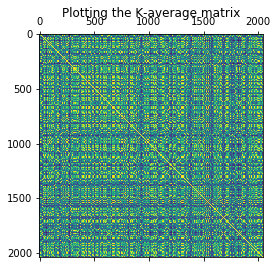

Text(0.5, 1.05, 'Plotting the K-average RBF matrix')

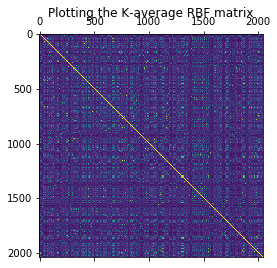

In [94]:
plt.matshow(dfKaverage, fignum=100)
plt.gca().set_aspect('auto')
plt.title('Plotting the K-average matrix')
plt.show()
plt.matshow(dfKaverageRBF, fignum=100)
plt.gca().set_aspect('auto')
plt.title('Plotting the K-average RBF matrix')

In [95]:
print ('training EasyMKL...', end='')
clf = EasyMKL(lam=0.1).fit(KLtr,Ytr)#combining kernels with the EasyMKL algorithm
clfEasyRBF = EasyMKL(lam=0.1).fit(ker_list,Ytr)
#lam is a hyper-parameter in [0,1]
print ('done')
print (clf.weights)

training EasyMKL...done
[7.40371527e-16 6.45669977e-02 1.92598068e-01 7.42834935e-01]


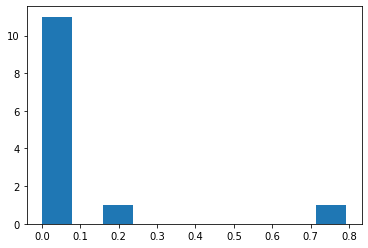

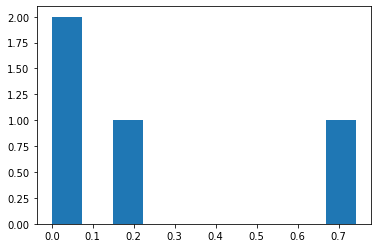

In [100]:
_=plt.hist(clfEasyRBF.weights)
plt.show()
_=plt.hist (clf.weights)

In [101]:
#evaluate the solution
from sklearn.metrics import accuracy_score, roc_auc_score 
y_pred = clf.predict(KLte)                 #predictions
y_score = clf.decision_function(KLte)      #rank
accuracy = accuracy_score(Yte, y_pred)
roc_auc = roc_auc_score(Yte, y_score)
print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))

Accuracy score: 0.983, roc AUC score: 0.806


In [ ]:
y_pred = clf.predict(KLte)                 #predictions
y_score = clf.decision_function(KLte)      #rank
accuracy = accuracy_score(Yte, y_pred)
roc_auc = roc_auc_score(Yte, y_score)
print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))

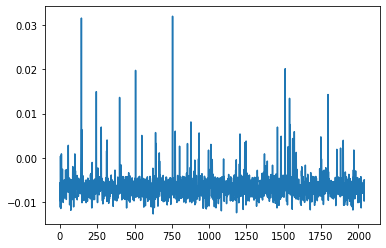

In [73]:
plt.plot(clf.decision_function(KLtr))

In [82]:
print ('tuning lambda for EasyMKL...', end='')
base_learner = SVC(C=10000)	#simil hard-margin svm
best_results = {}
for lam in [0, 0.01, 0.1, 0.2, 0.9, 1]:#possible lambda values for the EasyMKL algorithm
    #MKLpy.model_selection.cross_val_predict performs the cross validation automatically, it optimizes the accuracy
    #the counterpart cross_val_score optimized the roc_auc_score (use score='roc_auc')
    #WARNING: these functions will change in the next version
    scores = cross_val_predict(KLtr, Ytr, EasyMKL(learner=base_learner, lam=lam), n_folds=5, score='accuracy')
    acc = np.mean(scores)
    if not best_results or best_results['score'] < acc:
        best_results = {'lam' : lam, 'score' : acc}

tuning lambda for EasyMKL...

/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').